In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time

## Only run on weekends once

In [ ]:
today = date.today()
day = today.weekday()
week_start = today - timedelta(days = day)
if day > 4:
    print(f'Ok to continue for week {week_start}')
else:
    raise Exception('Not on weekend, please wait until weekend to run.')
weekend = today

Edit below next weekend

In [84]:
print(today)

2021-05-16


In [28]:
day = today.weekday()
week_start = today - timedelta(days = day)
#cptv_week_dict = {}
#rtt_week_dict = {}
cptv_week_df = pd.DataFrame()
rtt_week_df = pd.DataFrame()

for day_num in range(5):
    trading_day = today - timedelta(days = day-day_num)
    
    cptv_trading_day_path = f'closing_price_trade_volume_data/AMZN_cptv_{trading_day}.xls'
    cptv_trading_day_df = pd.read_excel(cptv_trading_day_path)
    cptv_trading_day_df.drop(columns=['Open', 'High', 'Low'], inplace=True)
    cptv_trading_day_df.drop(cptv_trading_day_df.tail(1).index, inplace=True)
    cptv_week_df = cptv_week_df.append(cptv_trading_day_df, ignore_index=True, sort=False)
    
    rtt_trading_day_path = f'real_time_trades_data/AMZN_rtt_{trading_day}.csv'
    rtt_trading_day_df = pd.read_csv(rtt_trading_day_path)
    rtt_trading_day_df.drop(columns=['Unnamed: 0'], inplace=True)
    rtt_week_df = rtt_week_df.append(rtt_trading_day_df, ignore_index=True, sort=False)

cptv_week_dict[week_start] = cptv_week_df

rtt_week_df['NLS Price'] = rtt_week_df['NLS Price'].map(lambda x: x.lstrip('$ '))
rtt_week_df['NLS Price'] = pd.to_numeric(rtt_week_df['NLS Price'])
rtt_week_df['NLS Share Volume'] = rtt_week_df['NLS Share Volume'].str.replace(',', '')
rtt_week_df['NLS Share Volume'] = pd.to_numeric(rtt_week_df['NLS Share Volume'])

rtt_week_dict[week_start] = rtt_week_df

In [100]:
cptv_week_csv = f'AMZN_cptv_{week_start}.csv'
cptv_week_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}')
rtt_week_csv = f'AMZN_rtt_{week_start}.csv'
rtt_week_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{rtt_week_csv}')

In [18]:
cptv_week_df['Close'].corr(cptv_week_df['Volume'])

0.03799743365257477

In [74]:
grouped_cptv_week_df = cptv_week_df.groupby(np.arange(len(cptv_week_df))//30).mean()

In [76]:
grouped_cptv_week_df.shape

(65, 4)

In [75]:
grouped_cptv_week_df.head()

,Close,Volume,rolling_close,rolling_volume
0,3250.815163,31102.300000,NaN,NaN
1,3233.172607,20152.733333,3234.855707,22120.226667
2,3224.522870,19040.300000,3224.671280,18563.176111
3,3213.543383,16599.233333,3216.687038,17265.819444
4,3219.370413,14470.166667,3218.691950,13441.675556


In [ ]:
close_price_series = cptv_week_df.loc[:, 'Close']
cptv_week_df = cptv_week_df.assign(rolling_close = close_price_series.rolling(60, center=True).mean())
close_volume_series = cptv_week_df.loc[:, 'Volume']
cptv_week_df = cptv_week_df.assign(rolling_volume = close_volume_series.rolling(60, center=True).mean())

In [83]:
cptv_week_df['Date'].iloc[0]

'2021-05-10 09-30'

In [99]:
cptv_week_df.shape

(1934, 5)

In [98]:
half_hour_segments = []
for i in np.arange(len(cptv_week_df))//30:
    half_hour_segments.append(cptv_week_df['Date'].iloc[i])
len(half_hour_segments)

1934

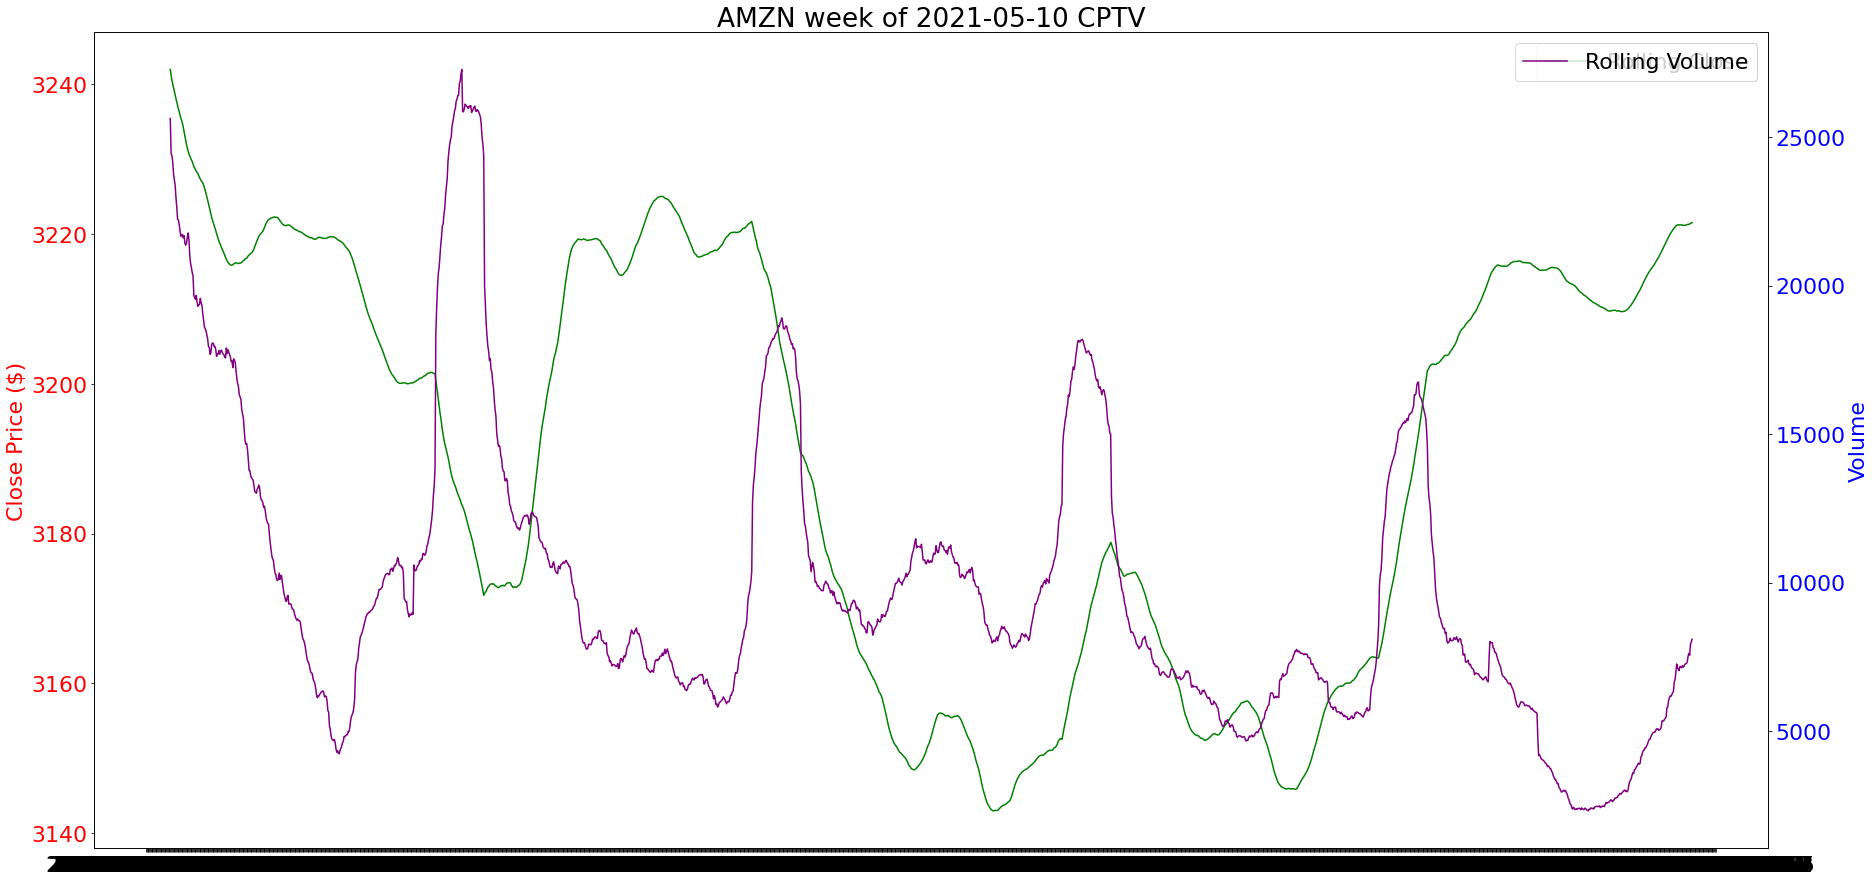

In [63]:
date_array = cptv_week_df.loc[:, 'Date']

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

#ax1.plot(date_array, cptv_week_df.loc[:, 'Close'], color='r', label='Close')
ax1.plot(date_array, cptv_week_df.loc[:, 'rolling_close'], color='g', label='Rolling Close')
ax1.set_ylabel('Close Price ($)', color ='r')
ax1.set_title(f'AMZN week of {week_start} CPTV')
ax1.tick_params(axis='y', labelcolor='r')
ax1.legend()

ax2 = ax1.twinx()
#ax2.plot(date_array, cptv_week_df.loc[:, 'Volume'], color='b', label='Volume')
ax2.plot(date_array, cptv_week_df.loc[:, 'rolling_volume'], color='purple', label='Rolling Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.legend()

plt.show()

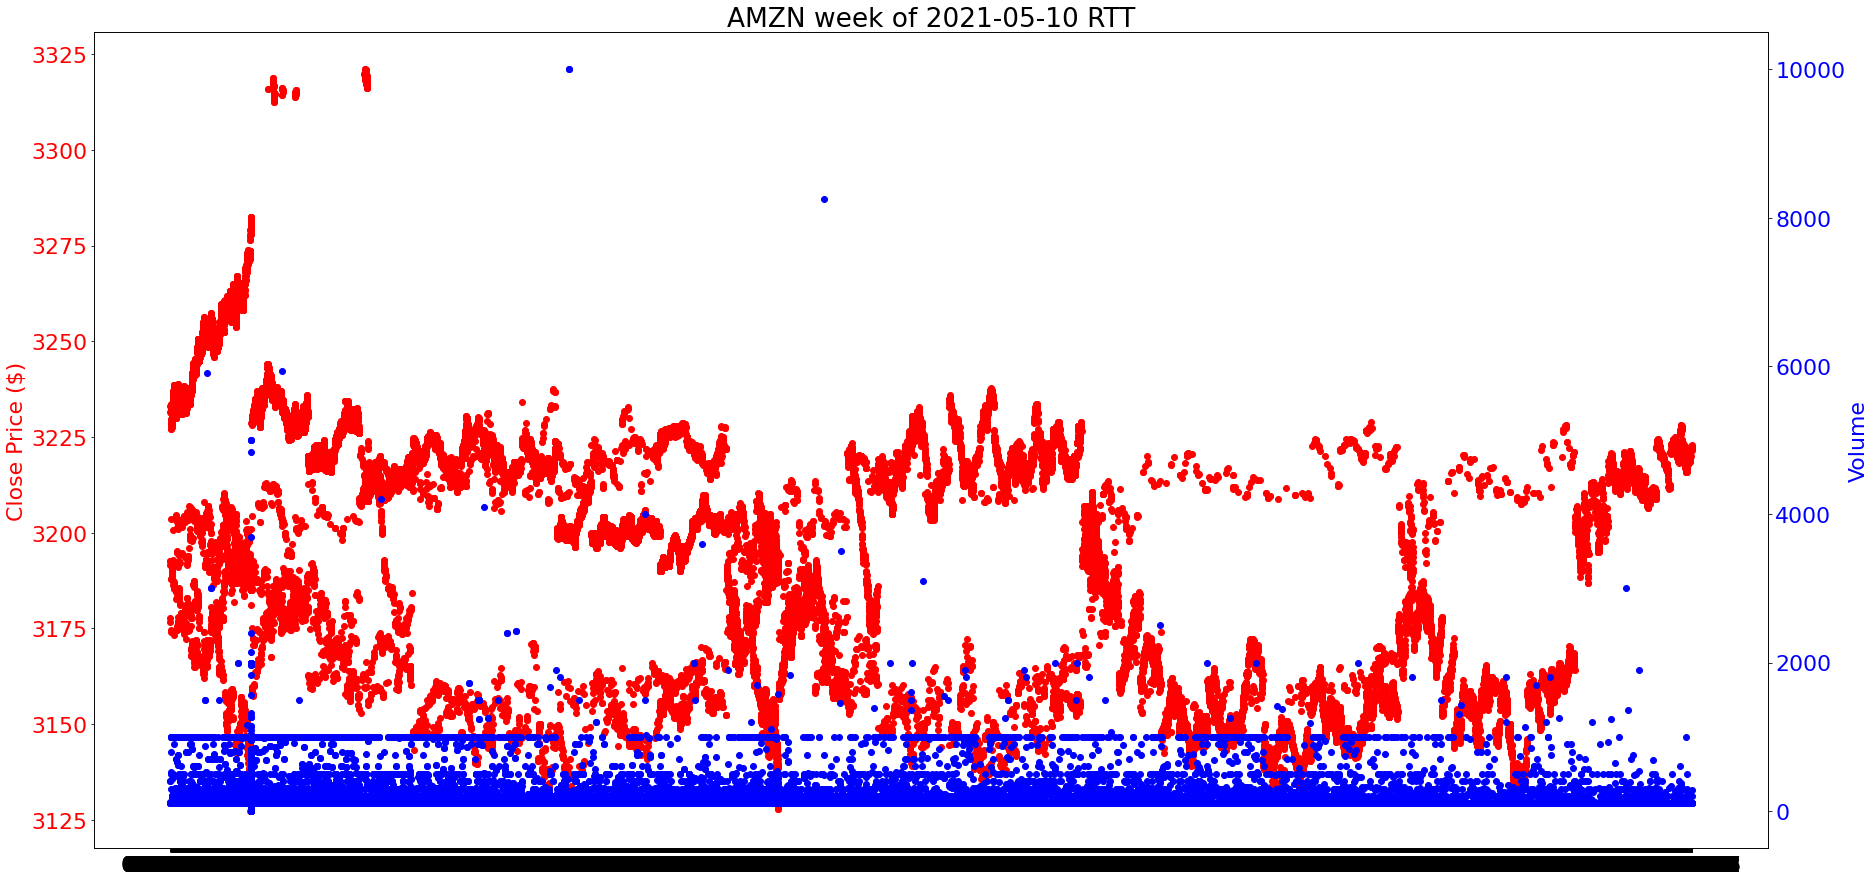

In [47]:
date_array = rtt_week_df.loc[:, 'NLS Time (ET)']

plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.scatter(date_array, rtt_week_df.loc[:, 'NLS Price'], color='r', alpha=0.5, label='NLS Price')
ax1.set_ylabel('Price ($)', color ='r')
ax1.set_title(f'AMZN week of {week_start} RTT')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.scatter(date_array, rtt_week_df.loc[:, 'NLS Share Volume'], color='b', alpha=0.5, label='NLS Share Volume')
ax2.set_ylabel('Volume', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.show()